# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information



## Laboratoire 5 - Régression linéaire
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                   | CODE PERMANENT                                   |
|------------------------|--------------------------------------------------|
| Hugo Rhéaume-Simard    | RHEH93080004                                     |
| Laurent Marleau-Gallant| MARL05109800                                     |
| Yulia Bakaleinik       | BAKY30539705                                     |

## Introduction
Dans ce laboratoire, vous êtes amenés à utiliser des algorithmes de régression aﬁn de résoudre le problème de prédiction de l'âge de personnes à partir de photos du visage.

Le problème de régression qui vous est présenté est le problème [Facial Aging Estimation (FAE)](https://yanweifu.github.io/FG_NET_data/index.html), dont le but est de prédire l'âge des personnes à partir du visage. En vous basant sur les concepts vus en classe et l'expérience acquise dans le laboratoires précedents, vous êtes invité à l’extraction de primitives puis la regression de l'âge sur l’ensemble de données fourni avec cet énoncé.

##### Description de l'ensemble de données FG-NET:
* 1002 images faciales de 82 sujets multiraciaux âgés de 0 à 69 ans;
* Déséquilibré: 50% des sujets ont entre 0 et 13 ans;
* Images couleur et niveaux de gris avec largeur entre 300 et 359 pixels, hauteur entre 639 et 772 pixels, et résolution entre 200 dpi et 1200 dpi;
* Grande variation d'éclairage, de pose, d'expression faciale, de flou et d'occlusions (par exemple, moustache, barbe, lunettes, etc.).

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données FG-NET:

![Exemples de FG-NET](https://www.mdpi.com/sensors/sensors-16-00994/article_deploy/html/images/sensors-16-00994-g001.png)

L’évaluation de ce laboratoire sera basée sur:
- la qualité des algorithmes proposés et utilisés; (10%)
- utilisation du protocole et mesures de performance appropriées; (10%)
- les réponses aux questions dans ce notebook (Les cellules dans votre PDF ou votre notebook doivent être processées dans votre rendu); (70%)
- l'organisation de votre code source (n'oubliez pas de mettre des commentaires dans le code source!) (10%)

# Modules et bibliotèques python

### Import de bibliotèques

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [2]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import pandas as pd
import os
import re
from PIL import Image
import numpy as np
import re 
import face_recognition
import cv2
from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

from skimage import io, exposure, filters, transform, color
from skimage.color import rgb2gray

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, top_k_accuracy_score

### Définition des fonctions

In [3]:
detector = MTCNN()

def detect_faces_face_recognition(image_array):
    # Detect faces
    face_locations = face_recognition.face_locations(image_array)

    # Return 1 if faces are detected, otherwise return 0
    return 1 if len(face_locations) > 0 else 0


def detect_faces_mtcnn(image_array):
    # Initialize the MTCNN face detector

    # Detect faces
    faces = detector.detect_faces(image_array)
    return 1 if len(faces) > 0 else 0


def getId_Age_from_fileName(fileName):
    s1 = fileName.split(".")
    
    s2 = s1[0].split("A")
    s2[1] = re.sub('[^0-9]','', s2[1])
    
    id = int(s2[0])
    age = int(s2[1])

    return id, age

def show_images(x, num_rows = 7, num_cols = 7, figsize=(12, 12),y = None,z = None, show_ages = False):
    plt.figure(figsize=figsize)
    for i in range(num_rows * num_cols):
        random_indexes = np.random.randint(0, len(x))
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(x[random_indexes], cmap='gray')
        if show_ages:
            plt.title(f"Age: {y[random_indexes]} ID: {z[random_indexes]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def resize_image(image, new_height, new_width):
    return transform.resize(image, (new_height, new_width))


# Partie 1 - Lecture des images et préparation des données (40%)

Point de départ: 1002 images jpeg de l'ensemble FG-NET

## 1a: Lecture, nettoyage, prétraitement, normalisation et annotation

Différemment de l'ensemble FER, l’ensemble FG-NET consiste en un répertoire avec 1,002 images JPEG, où les étiquettes sont les noms des fichiers (âge et l'id du sujet).

Vous devez lire ces images et les représenter sous la forme d’une matrice $X\_data$ aussi que transformer les noms des fichiers dans un vecteur $Y\_data$ avec les âges et un troisième vecteur $Z\_data$ avec les id des sujets.

Vous devez également, comme vous avez déjà fait pour l'ensemble de données FER, vous assurer qu’il n'y a pas:
- données aberrantes;
- valeurs manquantes;
- valeurs inapplicables ou aberrantes;
- etc.  
PS: Pour rebalancer, ne faite pas un simple upsampling, augmentez vos données.

Finalement, vous devez également appliquer de prétraitement pour réduire la variabilité, réduire des bruits, etc. En particulier, pour les images de visage, quelques prétraitements peuvent se montrer utiles, comme:
- Localisation/recadrage du visage?
- Localisation des yeux?
- Lissage du visage?
- Normalization du contraste?
- Etc.

#### 1. Lire les images jpeg et les noms des fichiers et les représenter sous la forme de matrices de pixels et vecteurs de étiquettes ($X\_data$, $Y\_data$, $Z\_data$ comme décrit précédemment).

In [4]:
foldername = "fgnet"
dir_list = os.listdir(foldername)
print(len(dir_list))

# Initialize the data arrays
X_data = np.zeros((len(dir_list), 256, 256, 3), dtype=np.uint8)
Y_data = np.zeros((len(dir_list), 1), dtype=int)
Z_data = np.zeros((len(dir_list), 1), dtype=int)
X_data_list = []    


dir_list.sort()

inti = 0
count = 0
for file in dir_list:
    filename = file

    id, age = getId_Age_from_fileName(filename)
    
    if id is not None and age is not None:
        Z_data[inti] = id
        Y_data[inti] = age
        
        # Open the image and resize to 256x256
        img_path = os.path.join(foldername, filename)
        with Image.open(img_path) as img:
            #img = img.resize((256, 256))
            img_array = np.array(img)

            if img_array.ndim == 2:  # Grayscale image
                img_array = np.stack((img_array,) * 3, axis=-1)
            
            if img_array.shape == (256, 256, 3):
                #X_data[inti] = img_array
                X_data_list.append(img_array)

            else:
                X_data_list.append(img_array)
               # X_data[inti] = img_array
                count += 1
                #print(f"Image shape mismatch for file: {filename}")
        
        inti +=1


print("Total images with shape mismatch: ", count)
print(X_data.shape)
print(X_data_list[0].shape)
print(Y_data.shape)
print(Z_data.shape)

for i in range(0, 10):
    print("ID = ", Z_data[i], " Age = ", Y_data[i])


1002
Total images with shape mismatch:  1002
(1002, 256, 256, 3)
(386, 321, 3)
(1002, 1)
(1002, 1)
ID =  [1]  Age =  [2]
ID =  [1]  Age =  [5]
ID =  [1]  Age =  [8]
ID =  [1]  Age =  [10]
ID =  [1]  Age =  [14]
ID =  [1]  Age =  [16]
ID =  [1]  Age =  [18]
ID =  [1]  Age =  [19]
ID =  [1]  Age =  [22]
ID =  [1]  Age =  [28]


#### 2. Concevez et codifiez un algorithme pour vérifier l'intégrité des données, faire des corrections si nécessaires.


In [5]:
inti = 0
nmb = 0
bad_images = []
indexes = []
for images in X_data_list:
    #do something to check if the images are okay
    if images.shape != (256, 256, 3):
        #print("Image shape is not correct")
        pass
    if images.dtype != np.uint8:
        print("Image type is not uint8")
    if images.max() > 255 or images.min() < 0:
        print("Image pixel values are out of range")
    mean = np.mean(images)
    if mean < 0 or mean > 255:
        print("Image mean is out of range")
    if np.std(images) < 1 or np.std(images) > 255:
        print("Image std is out of range")
    if np.isnan(images).any():
        print("Image contains NaNs")
    if detect_faces_face_recognition(images) != 1:
        print("Face not detected for image", inti,  Z_data[inti], Y_data[inti])
        #plt.imshow(images)
        #plt.show()
        bad_images.append(images)
        indexes.append(inti)
        nmb += 1
    inti += 1
print("Total images with no faces detected: ", nmb)
    

for age in Y_data:
    #do something to check if the ages are okay
    if age<0 or age > 100:
        print("Age is out of range")

for id in Z_data:
    #do something to check if the ids are okay
    if id<0 or id > 1000:
        print("ID is out of range")


Face not detected for image 122 [10] [10]
Face not detected for image 168 [14] [3]
Face not detected for image 264 [22] [7]
Face not detected for image 299 [25] [0]
Face not detected for image 300 [25] [3]
Face not detected for image 393 [33] [2]
Face not detected for image 445 [37] [1]
Face not detected for image 458 [38] [3]
Face not detected for image 526 [43] [13]
Face not detected for image 532 [44] [1]
Face not detected for image 542 [45] [3]
Face not detected for image 543 [45] [6]
Face not detected for image 545 [45] [12]
Face not detected for image 554 [45] [48]
Face not detected for image 582 [48] [0]
Face not detected for image 652 [54] [2]
Face not detected for image 684 [57] [12]
Face not detected for image 694 [58] [4]
Face not detected for image 750 [63] [8]
Face not detected for image 758 [64] [3]
Face not detected for image 791 [67] [14]
Face not detected for image 794 [67] [23]
Face not detected for image 901 [76] [0]
Face not detected for image 903 [76] [2]
Face not 

In [6]:
cnt = 0
index_to_remove = []
for index, images in enumerate(bad_images):
    faces = detect_faces_mtcnn(images)
    if faces > 0:
        #print("Faces detected")
        pass
    else:
        cnt += 1
        #plt.imshow(images)
        #plt.show()
        #print("No faces detected")
        #print("Index: ", indexes[index], " ID: ", Z_data[indexes[index]], " Age: ", Y_data[indexes[index]])
        index_to_remove.insert(0, indexes[index])    

print(index_to_remove)
print("Total images with no faces detected: ", cnt)



1/1 [==============================] - 0s 22ms/step
[299, 168]
Total images with no faces detected:  2


In [7]:
#Delete les images qui ne reconnaissent pas des visages

for index in index_to_remove:
    X_data_list.pop(index)
    Y_data = np.delete(Y_data, index)
    Z_data = np.delete(Z_data, index)
 
index_to_remove.clear()

print(len(X_data_list))
print(Y_data.shape)
print(Z_data.shape)


1000
(1000,)
(1000,)


#### 3. Appliquez au moins un prétraitement sur les images de visages. Vous pouvez choisir différents algorithmes de prétraitement d’images dans [scikit-image](https://scikit-image.org/docs/stable/api/api.html) ou dans la librairie de votre choix. Vous pouvez aussi trouver d’autres types de prétraitement qui sont plus généraux dans [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing). Vous pouvez utiliser les mêmes prétraitements que ceux utilisés avec FER.


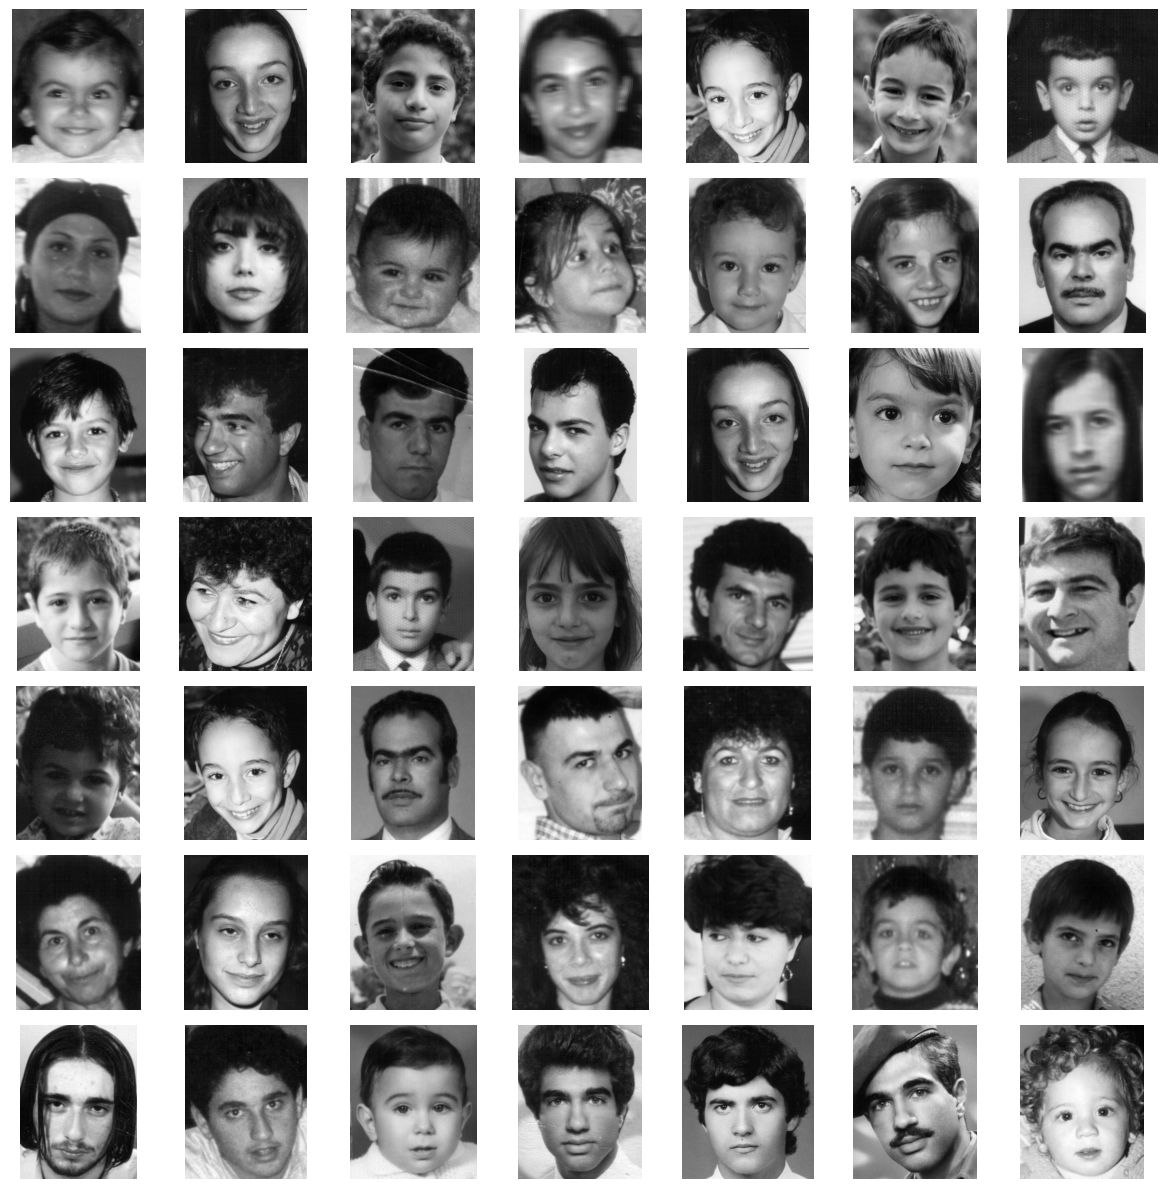

In [9]:
# Normalisation des pixels à une plage spécifique
def normalize_image(image_array):
    scaler = MinMaxScaler()
    normalized_image = scaler.fit_transform(image_array.reshape(-1, 1)).reshape(image_array.shape)
    return normalized_image

# Conversion d'une image RGB en niveaux de gris
def rgb_to_gray(image_array):
    gray_image = rgb2gray(image_array)
    return gray_image

# Amélioration du contraste d'une image
def enhance_contrast(image_array):
    #enhanced_image = exposure.equalize_hist(image_array, nbins=128, mask=None)
    #enhanced_image = exposure.adjust_gamma(image_array, gamma=0.8, gain=0.5)
    blurred_image = filters.gaussian(image_array, sigma=1)

    enhanced_image = exposure.equalize_adapthist(blurred_image, clip_limit=0.03, nbins=128)
    #Todo: Implement the contrast enhancement algorithm of your choice
    enhanced_image = image_array

    return enhanced_image

def preprocess_image(image_array):
    # Normalize the image
    normalized_image = normalize_image(image_array)
    # Convert the image to grayscale
    grayscale_image = rgb_to_gray(normalized_image)
    # Enhance the contrast of the image
    contrast_image = enhance_contrast(grayscale_image)
    
    return contrast_image

X_data_processed = []

for image in X_data_list:
    X_data_processed.append(preprocess_image(image))

show_images(X_data_processed)


#### 4. Choisir et appliquer une résolution $n\times m$ qui vous semble pertinente pour normaliser les images, car celles-ci n'ont pas toutes la même résolution.

Average height:  497.436
Average width:  404.847
Average ratio:  0.8138675126046365
For a decision of having a 128 height, the width should be:  103.68
The height should be:  128
The width should be:  104
The ratio is:  0.8125


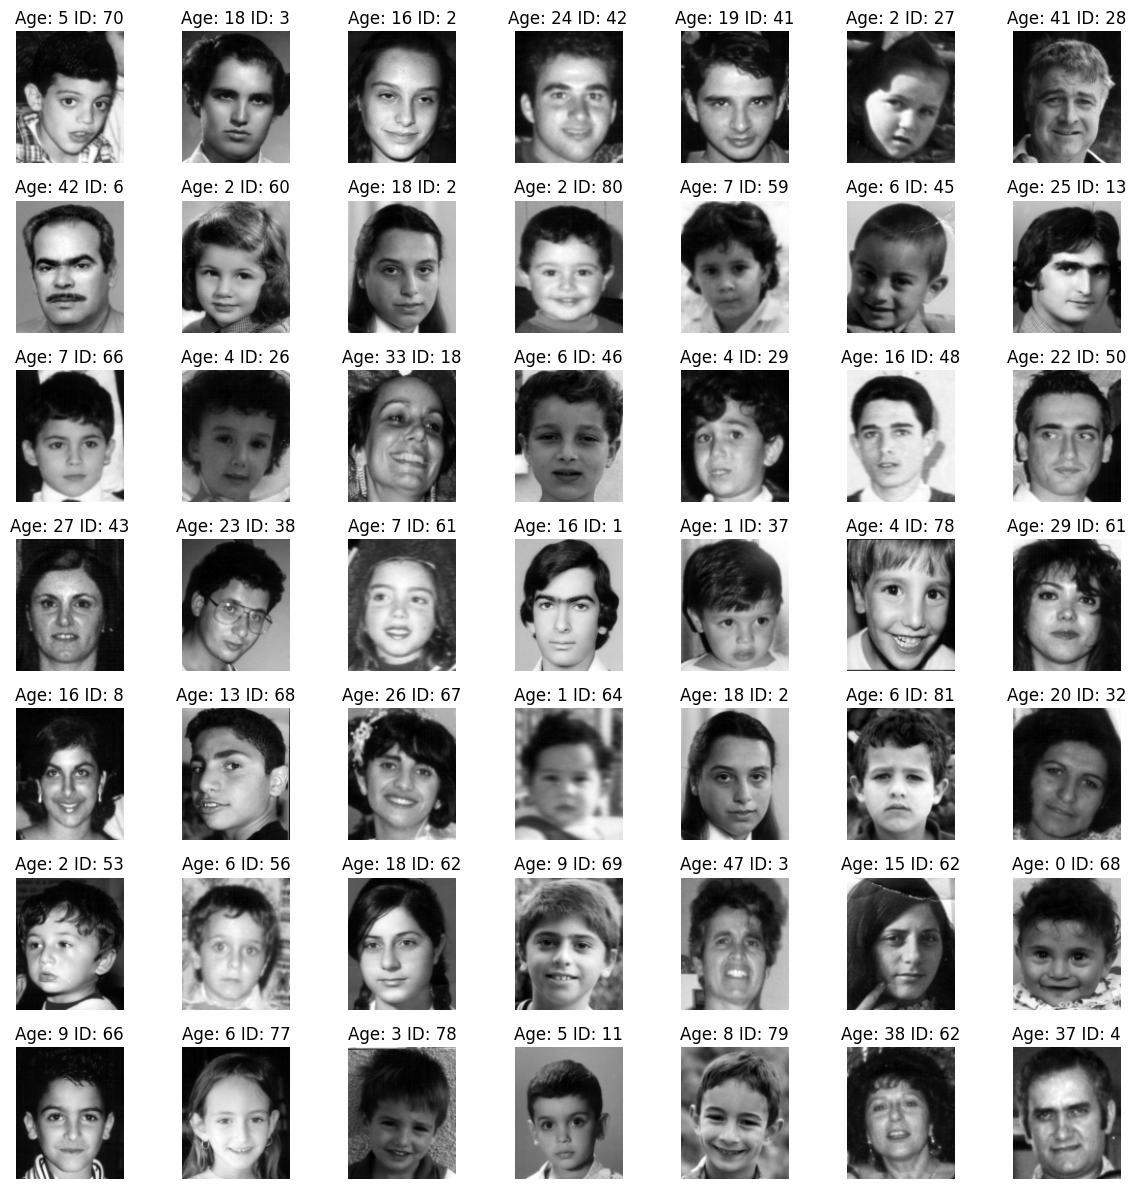

In [10]:
height = 0
width = 0
for images in X_data_list:
    height += images.shape[0]
    width += images.shape[1]

ratio = width/height
print("Average height: ", height/len(X_data_list))
print("Average width: ", width/len(X_data_list))
print("Average ratio: ", width/height)
#Knowing this, we should keep a 0.81 ratio for the images

print("For a decision of having a 128 height, the width should be: ", 128*0.81)

n = 128
m = n*ratio
m = int(m)

print("The height should be: ", n)
print("The width should be: ", m)
print("The ratio is: ", m/n)



X_data_resized = []
for image in X_data_processed:
    resized_image = resize_image(image, n, m)
    X_data_resized.append(resized_image)


show_images(X_data_resized,y =Y_data,z = Z_data, show_ages=True)

#### 5. Transformez toutes les images afin que celles-ci soient toutes définies sur les 3 canaux (RGB).


In [11]:
X_data_3channels = []   

for image in X_data_resized:
    X_data_3channels.append(np.stack((image,) * 3, axis=-1))

X_data_3channels = np.array(X_data_3channels, dtype=np.float32)

print(X_data_3channels.shape)
print(Y_data.shape)
print(Z_data.shape)


(1000, 128, 104, 3)
(1000,)
(1000,)


#### 6. Générez un fichier *fg-net-nxm.csv* avec les données nettoyées et normalisées, où $n$ et $m$ représentent la résolution finale des images.
   - Format du fichier: subject,age,pixels
      * sujet: integer
      * âge: integer
      * pixels: integer [0, 255]

In [12]:
data = []
for i in range(len(X_data_resized)):
    img_gray = X_data_list[i]

    img_rgb = X_data_3channels[i]

    # Flatten the image channels
 
    ch_ = img_rgb.flatten()
    # Flatten the image channels

    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [Z_data[i], Y_data[i] ,ch_str]
    data.append(row)

# Create a DataFrame
columns = ['id', 'age', 'pixels']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv(f"content/fg-net-{n}x{m}.csv", index=False)


In [13]:
#Check to see that everything is okay
ferData = pd.read_csv(f"content/fg-net-{n}x{m}.csv", delimiter=',', dtype={'id': int, 'age': int, 'pixels': str})

Z_data = ferData['id'].values
Y_data = ferData['age'].values

X_pixel = ferData['pixels'].values
X_split_pixel = [x.split(" ") for x in X_pixel]

print(len(X_split_pixel[0]))

X_pixel = np.array(X_split_pixel, dtype='float32')
X_pixel = X_pixel.reshape(X_pixel.shape[0], n, m, 3)

print(X_pixel.shape)

39936
(1000, 128, 104, 3)


#### 7. Décrivez brièvement les étapes de votre algorithme/code.
    1. Prendre les images, split le nom de l'image pour avoir l'id et l'age du sujet.
    2. Sauvegarde les images dans un X_data_list, l'id et l'age dans leur np array correspondant.
    3. Regarde si des visages sont detectés dans chaques images, si les moyennes sont trop basse ou trop haute et si nous ne remplissons pas ses conditons, nous enlevons les images.
    4. Pre-traitement: Dans le pre-traitement nous faisons une normalisation, une conversion au grayscale, un lissage gaussien et ensuite nous faisons une augmentation du contraste.
    5. Par la suite, nous transformons les images pour être dans un modele de 128 par 128 pixels, quoiqu'on pourrait revisiter pour faire en sorte de garder les rations auriginels.

#### 8. Créer une grille de dimension $7\times 2$ avec des images de visage prises aléatoirement de l'ensemble FG-NET original et après vos traitements. Afficher également l'âge et le id du sujet au dessus de chaque image.



Avant traitement


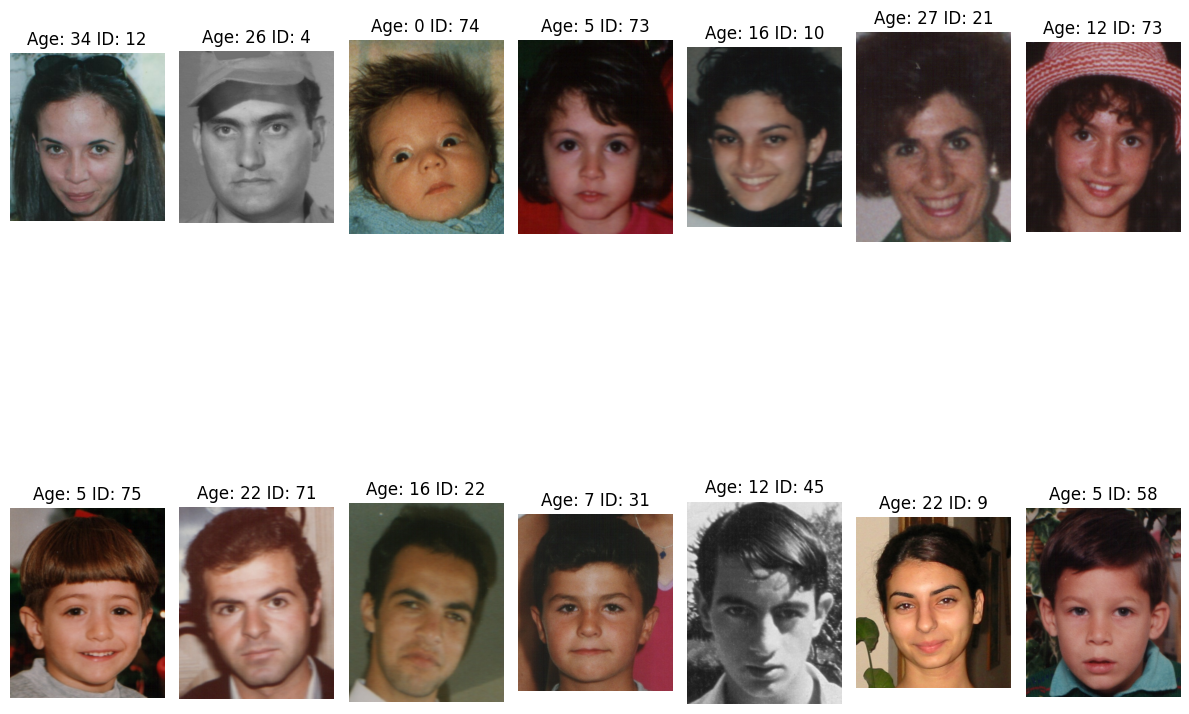

Apres traitement


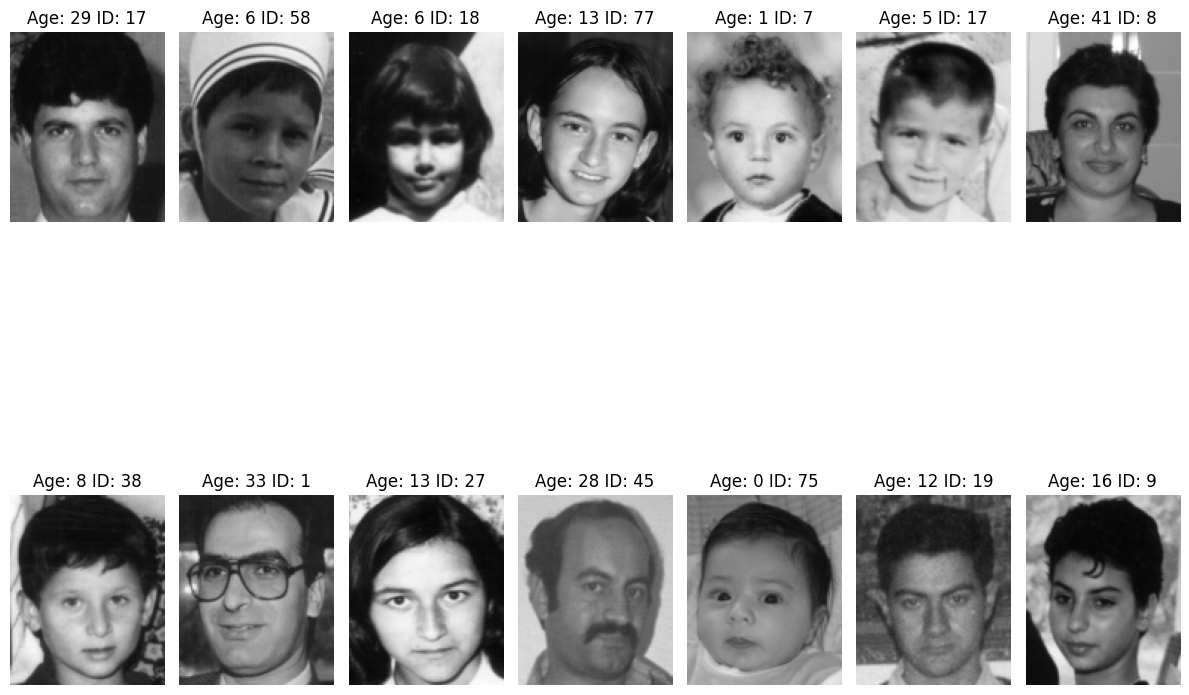

In [14]:
print("Avant traitement")
show_images(X_data_list, 2, 7, y = Y_data, z = Z_data, show_ages=True)

print("Apres traitement")
show_images(X_pixel, 2, 7, y = Y_data, z = Z_data, show_ages=True)

# Partie 2 - Extraction de primitives (10%)

#### 1. Choisir et extraire un jeu de primitives pour représenter les images de FG-NET. Vous êtes fortement conseillé de choisir le jeu de primitives les plus performants dans les TPs précédents (primitives artisanaux, deep, deep réduit, etc.)

In [15]:
# Load the ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(n, m, 3))

# Extract features from the specific layer
layer_name = "conv4_block6_out"

model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Freeze the layers
for layer in model.layers:
    layer.trainable = False

X_feature = model.predict(X_pixel)
X_feature = X_feature.reshape(X_feature.shape[0], -1)

print(f"ResNet50V2 : {X_feature.shape[1]} features")

32/32 [==============================] - 2s 26ms/step
ResNet50V2 : 16384 features


#### 2. Sauvegardez vos vecteurs de primitives sous la forme d'un fichier 'csv' (p. ex. *fgnet-deepVGG19.csv*). N'oubliez pas d'utiliser toujours la même structure du fichier *fg-net-nxm.csv* de 1a). Vous devez nommer vos fichiers de primitives en référence au jeu de primitives utilisé, p. ex., *fg-net-12x12-deepVGG19.csv* pour des primitives produites avec une CNN VGG19.

In [16]:
data = []
for i in range(len(X_feature)):
    # Flatten the image channels
    ch_ = X_feature[i].flatten()
    # Flatten the image channels
    #ch_str = ' '.join(map(str, ch_))
    
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [Z_data[i], Y_data[i] ,ch_str]
    data.append(row)

# Create a DataFrame
columns = ['id', 'age', 'features']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv(f'content/fg-net-128x104-restNET50v2.csv', index=False)



#### 3. Décrivez très brièvement le choix du jeu de primitives.

Le choix était de prendre l'algo RESNET50V2 et de l'appliquer sur toutes les données d'entrainement ensuite nous avons appliquer un PCA pour seulement avoir 500 composant à la fin, puisque la classification est differente, aucune algo de selection des primitive est utiliser dans notres situation mais ça pourrait être une possibilité

# Partie 3: Entraînement de modèles de régression (20%)

Vous êtes maintenant prêtes à entraîner un modèle d'apprentissage automatique avec les vecteurs de primitives extraits dans la Partie 2.

#### 1. Choisir deux (2) algorithmes de régression disponibles dans Scikit-learn:
* Régression lineaire
* Régression Ridge
* Régression Lasso et Elastic-Net
* Descente du gradiente stochastique (SGD)<br>

Conseil: Étudiez les algorithmes choisis pour bien comprendre les différents hyperparamètres qui peuvent affecter l'entraînement, la généralisation et la complexité du modèle de régression.

<b>Algorithmes choisis :</b> `Linear Regression` et `Ridge Regression`

#### 2. Entraîner et optimiser les paramètres des modèles de régression. Utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).
(voir prochaine section)

#### 3. Étudiez les metriques d'évaluation des modèles de régression disponibles dans [Scikit-Learn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) puis utilisez MSE, MAE et une troisième metrique de votre choix.

In [17]:
#data = np.loadtxt('content/fg-net-128x104.csv', delimiter=',',dtype=str)
data = np.loadtxt('content/fg-net-128x104-restNET50v2.csv', delimiter=',',dtype=str)

def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

x_data = transform_str_float(data[1:,2])
y_data = np.array(data[1:,1], dtype=int)
z_data = np.array(data[1:,0], dtype=int)

print(f"fg-net:\t{x_data.shape[1]} features")

pca = PCA(n_components=1000)
x_data = pca.fit_transform(x_data)

print(f"pca:\t{x_data.shape[1]} features")

fg-net:	16384 features
pca:	1000 features



K Neighbors Classifier
Average MSE: 235.92994111241057
Average MAE: 10.455519328232745
Average R2 Scores: -1.2110998216417503
Average Accuracy: 8.24%


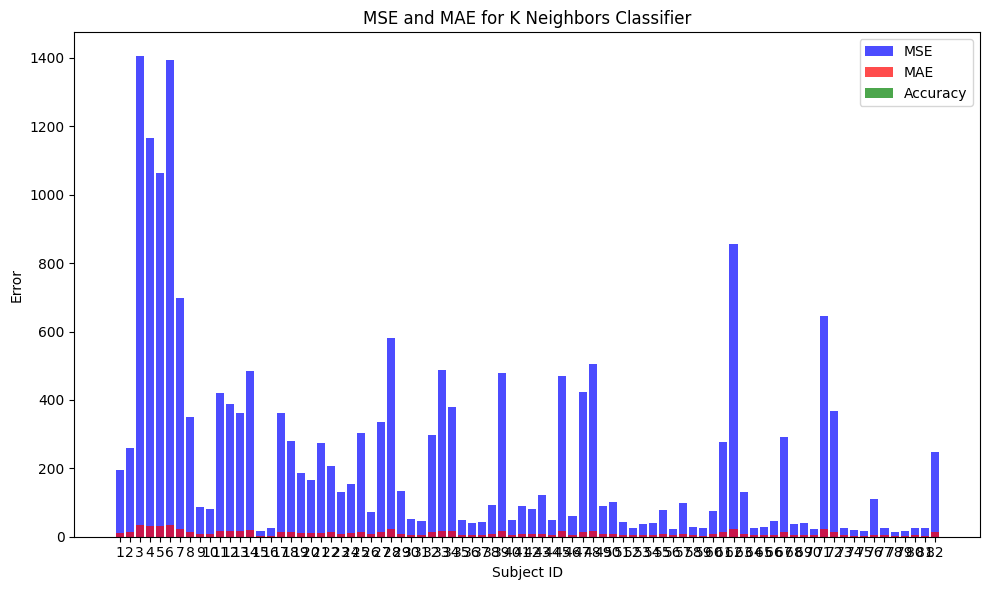


Linear Regression
Average MSE: 94.95687654987984
Average MAE: 7.466015426194832
Average R2 Scores: -0.6585243552641729
Average Accuracy: 4.61%


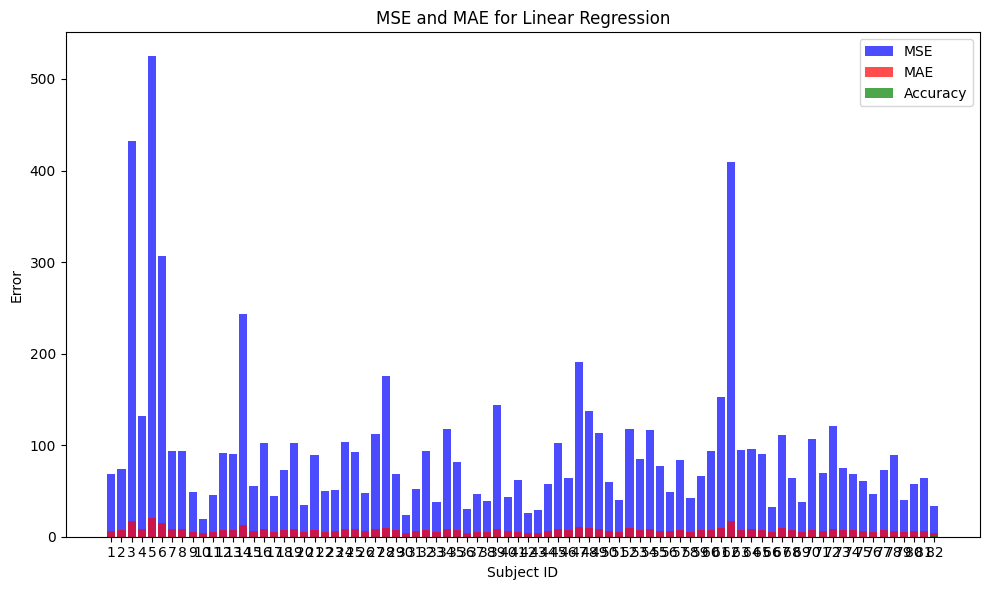


Ridge Regression
Average MSE: 94.90621207217919
Average MAE: 7.463616081341751
Average R2 Scores: -0.6573717117535586
Average Accuracy: 4.72%


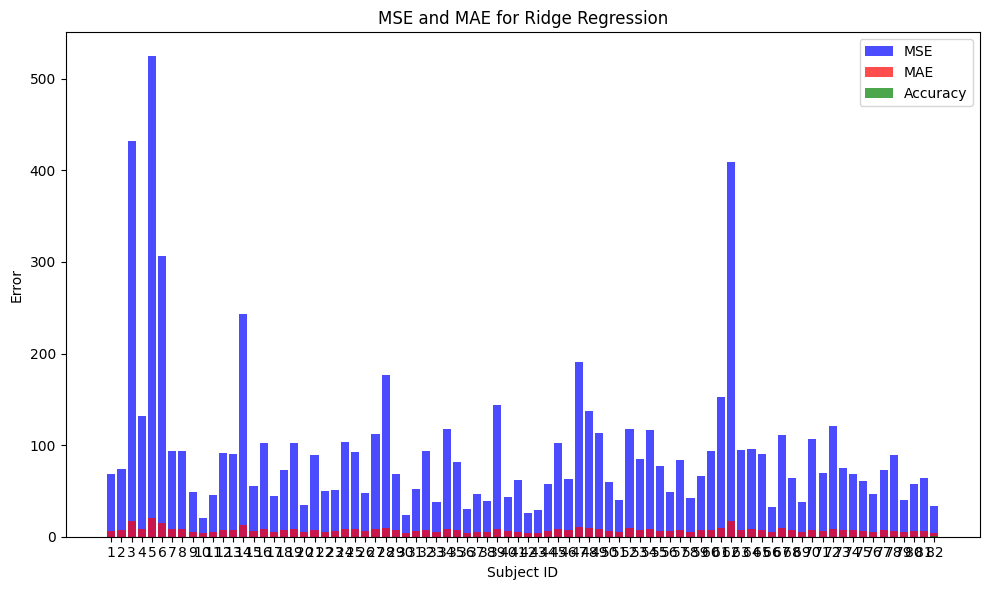

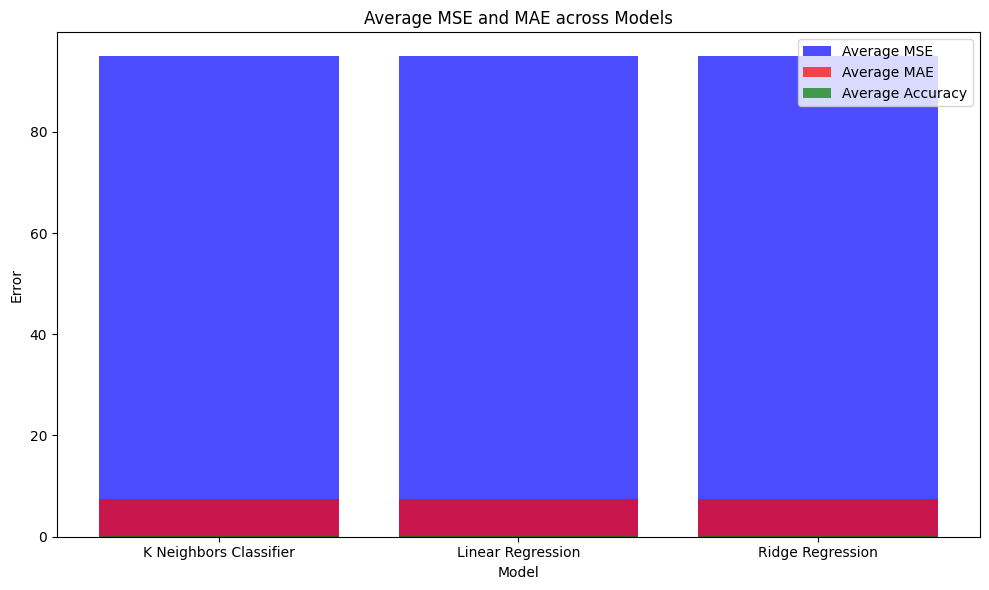

In [19]:
logo = LeaveOneGroupOut()
models = {
    "K Neighbors Classifier": KNeighborsClassifier(n_neighbors=4),
    "Linear Regression": LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None),
    "Ridge Regression": Ridge(alpha=0.7, fit_intercept=True, solver='saga')
}

for model_name, model in models.items():
    print(f"\n{model_name}")

    subject_ids = []
    mse_scores = []
    mae_scores = []
    r2scores = []
    accuracy_scores = []

    avg_mse_values = []
    avg_mae_values = []
    avg_scores_values = []
    avg_accuracy_values = []

    for train_index, test_index in logo.split(x_data, y_data, groups=z_data):
        x_train = x_data[train_index]
        y_train = y_data[train_index]

        x_test = x_data[test_index]
        y_test = y_data[test_index]

        model.fit(x_train,y_train)
        #model.intercept_
        #model.coef_

        y_pred = model.predict(x_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        
        r2scores.append(r2_score(y_test, y_pred))

        y_test_labels = np.round(y_test).astype(int)
        y_pred_labels = np.round(y_pred).astype(int)
        accuracy = accuracy_score(y_test_labels, y_pred_labels)
        accuracy_scores.append(accuracy)
        #print(f'{model_name} accuracy:\t{round(accuracy * 100, 2)}%')

        # Collect subject IDs
        subject_ids.append(z_data[test_index][0])  

    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    avg_score = np.mean(r2scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"Average MSE: {avg_mse}")
    print(f"Average MAE: {avg_mae}")
    print(f"Average R2 Scores: {avg_score}")
    print(f"Average Accuracy: {round(avg_accuracy *100, 2)}%")

    avg_mse_values.append(avg_mse)
    avg_mae_values.append(avg_mae)
    avg_scores_values.append(avg_score)
    avg_accuracy_values.append(avg_accuracy)

    # Plot MSE and MAE for each model
    plt.figure(figsize=(10, 6))
    plt.bar(subject_ids, mse_scores, alpha=0.7, color='b', label='MSE')
    plt.bar(subject_ids, mae_scores, alpha=0.7, color='r', label='MAE')
    plt.bar(subject_ids, accuracy_scores, alpha=0.7, color='g', label='Accuracy')
    plt.xlabel('Subject ID')
    plt.ylabel('Error')
    plt.title(f'MSE and MAE for {model_name}')
    plt.legend()
    plt.xticks(subject_ids)
    plt.tight_layout()
    plt.show()

# Plot average MSE and MAE for all models
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(models)), avg_mse_values, alpha=0.7, color='b', label='Average MSE')
plt.bar(np.arange(len(models)), avg_mae_values, alpha=0.7, color='r', label='Average MAE')
plt.bar(np.arange(len(models)), avg_accuracy_values, alpha=0.7, color='g', label='Average Accuracy')
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Average MSE and MAE across Models')
plt.xticks(np.arange(len(models)), models.keys())
plt.legend()
plt.tight_layout()
plt.show()

#### 4. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les algorithmes de régression choisis.

Les résultats montrent une accuracy très faible de 4.xx% suite à l'utilisation de PCA avec 1000 composants principaux, choisi pour minimiser MSE et MAE. La réduction des caractéristiques de 16384 à 1000 et la résolution des images par ResNet50v2 ont également impacté les performances. Les modèles de régression linéaire et Ridge, bien que efficaces pour la régression, ne conviennent pas bien pour des tâches de classification avec des données réduites par PCA. Pour améliorer les résultats, il est crucial de réévaluer le nombre de composants principaux en optimisant aussi pour l'accuracy, d'ajuster la résolution des images, et d'utiliser des modèles de classification adaptés, comme les SVM ou les réseaux de neurones

| Algorithme            | Paramètres    |  MSE  |  MAE  | Accuracy |
|-----------------------|---------------|-------|-------|----------|
| Regr lineaire         |               |94.96  | 4.47  |  4.61%   |
| Regr Ridge            | alpha = 0.7   |94.91  | 7.46  |  4.72%   |
| KNN                   | k = 4         |235.93 | 10.46 |  8.24%   |

# Fin